In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
# Load data
d = pd.read_csv("turnout_train.csv")
ta = pd.read_csv("turnout_to_assign.csv")

In [3]:
d.columns

Index(['id', 'state', 'treat', 'voted_2006', 'voted_2008', 'voted_2009',
       'voted_2010', 'voted_2011', 'voted_2012', 'voted_2013', 'voted_2014',
       'i_age', 'age_miss', 'voting_history_label', 'black', 'hispanic',
       'other_race', 'white', 'female', 'notfem', 'married'],
      dtype='object')

In [4]:
# no treat, voted_2014. 
# We want to know whether to treat them or not by predicting the differences in Pr(voted_2014) between the treated and untreated.
ta.columns

Index(['id', 'state', 'voted_2006', 'voted_2008', 'voted_2009', 'voted_2010',
       'voted_2011', 'voted_2012', 'voted_2013', 'i_age', 'age_miss',
       'voting_history_label', 'black', 'hispanic', 'other_race', 'white',
       'female', 'notfem', 'married'],
      dtype='object')

### Insights
- States: Keep only AZ, WI, MI
- Voting behavior: Keep voted_2006, voted_2008, voted_2009, voted_2011 (on top of voted_2010 and voted_2012), Remove voted_2013
- Voting history label: Keep all values
- Female: Remove
- Hispanic: Keep
- Black: Remove
- Married: Keep
- Age: Remove. Even having 2 buckets significantly reduces performance.


In [5]:
# Combine data and create train/test split
comb = pd.concat([d, ta], ignore_index=True)

# Keep selected variables
comb = comb[['id', 'state', 'treat', 'voted_2006', 'voted_2008', 'voted_2009', 'voted_2010', 'voted_2011', 'voted_2012', 'voted_2014', 'voting_history_label', 'married', 'hispanic']]

# Only keep AZ and WI, else set everything in 'state' to 'other'
comb['state'] = comb['state'].apply(lambda x: x if x in ['AZ', 'WI', 'MI'] else 'other') # having these 3 states help

comb['to_assign'] = comb['voted_2014'].isna() # people for which we want to assign treatment
train_idx = comb[~comb['to_assign']].sample(frac=1, random_state=72540).index # train set
comb['train'] = comb.index.isin(train_idx)
comb

,id,state,treat,voted_2006,voted_2008,voted_2009,voted_2010,voted_2011,voted_2012,voted_2014,voting_history_label,married,hispanic,to_assign,train
0,2426706,AZ,0.0,0,1,0,0,0,1,0.0,above,0,0,False,True
1,2426707,other,1.0,0,1,0,1,0,1,0.0,above,0,0,False,True
2,2426709,other,1.0,0,1,0,0,0,1,1.0,average,0,0,False,True
3,2426710,other,1.0,0,0,0,1,0,1,1.0,average,0,0,False,True
4,2426711,WI,1.0,0,1,0,1,0,1,1.0,above,0,0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826357,4414214,WI,NaN,1,1,0,1,0,1,NaN,above,0,0,True,False
2826358,4414215,other,NaN,0,1,0,1,0,1,NaN,above,0,0,True,False
2826359,4414216,other,NaN,0,1,0,1,1,1,NaN,above,1,0,True,False
2826360,4414217,other,NaN,1,0,0,0,0,1,NaN,average,0,0,True,False


In [6]:
# Fit separate models for treatment and control
if 'voting_history_label' in comb.columns:
    comb = pd.get_dummies(comb, columns=['voting_history_label'], drop_first=True)
if 'state' in comb.columns:
    comb = pd.get_dummies(comb, columns=['state'], drop_first=True)

# Change True to 1 and False to 0 for all columns
for col in comb.columns:
    if comb[col].dtype == 'bool':
        comb[col] = comb[col].astype(int)


comb_train = comb[(comb['train'] == 1) & (comb['to_assign'] == 0)]
comb_test = comb[(comb['train'] == 0) & (comb['to_assign'] == 0)]
comb_to_predict = comb[comb['to_assign'] == 1]

X_train_id = comb_train['id']
X_test_id = comb_test['id']
X_to_predict_id = comb_to_predict['id']

X_train = comb_train.drop(['id', 'voted_2014', 'to_assign', 'train'], axis=1)
X_test = comb_test.drop(['id', 'voted_2014', 'to_assign', 'train'], axis=1)
X_to_predict = comb_to_predict.drop(['id', 'voted_2014', 'to_assign', 'train'], axis=1)

X_train_treat = X_train[X_train['treat'] == 1]
X_train_control = X_train[X_train['treat'] == 0]
X_test_treat = X_test[X_test['treat'] == 1]
X_test_control = X_test[X_test['treat'] == 0]

y_train_treat = comb_train[comb_train['treat'] == 1]['voted_2014']
y_train_control = comb_train[comb_train['treat'] == 0]['voted_2014']
y_test_treat = comb_test[comb_test['treat'] == 1]['voted_2014']
y_test_control = comb_test[comb_test['treat'] == 0]['voted_2014']

X_train_treat = X_train_treat.drop('treat', axis=1)
X_train_control = X_train_control.drop('treat', axis=1)
X_train = X_test.drop('treat', axis=1)
X_test = X_test.drop('treat', axis=1)
X_test_treat = X_test_treat.drop('treat', axis=1)
X_test_control = X_test_control.drop('treat', axis=1)
X_to_predict = X_to_predict.drop('treat', axis=1)

In [7]:
X_train_treat

,voted_2006,voted_2008,voted_2009,voted_2010,voted_2011,voted_2012,married,hispanic,voting_history_label_average,voting_history_label_below,state_MI,state_WI,state_other
1,0,1,0,1,0,1,0,0,0,0,0,0,1
2,0,1,0,0,0,1,0,0,1,0,0,0,1
3,0,0,0,1,0,1,0,0,1,0,0,0,1
4,0,1,0,1,0,1,0,0,0,0,0,1,0
6,0,0,0,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1412138,1,0,0,0,0,0,0,0,0,1,0,0,1
1412140,0,0,0,0,0,1,0,0,0,1,0,0,1
1412141,0,0,0,0,1,0,0,0,0,1,0,0,1
1412142,0,1,0,1,0,0,0,0,0,1,0,0,1


## Logistic Regression

In [8]:
# Logistic Regression
scaler_treat = preprocessing.StandardScaler().fit(X_train_treat)
scaler_control = preprocessing.StandardScaler().fit(X_train_control)

model_treat = LogisticRegression().fit(scaler_treat.transform(X_train_treat), y_train_treat)
model_control = LogisticRegression().fit(scaler_control.transform(X_train_control), y_train_control)

<Axes: >

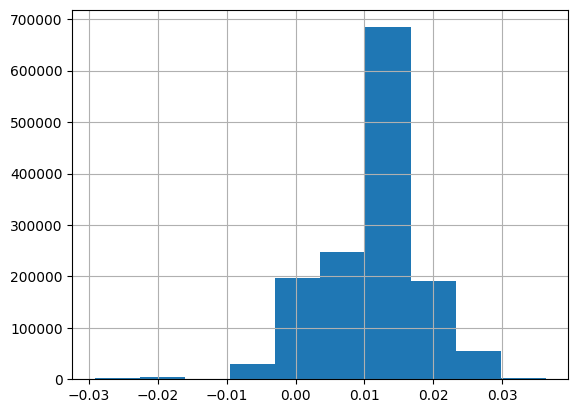

In [9]:
# Get predictions
predictions = X_to_predict.copy()
predictions['y_1_hat'] = model_treat.predict_proba(scaler_treat.transform(X_to_predict))[:, 1]
predictions['y_0_hat'] = model_control.predict_proba(scaler_control.transform(X_to_predict))[:, 1]
predictions['est_effect'] = predictions['y_1_hat'] - predictions['y_0_hat']
predictions['treat'] = (predictions['est_effect'] > 0.0053) * 1
predictions['est_effect'].hist()

In [10]:
# Get time now in string
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


In [11]:
df_to_submit = X_to_predict_id.to_frame()
df_to_submit['treat'] = predictions['treat']
df_to_submit.to_csv(f"df_to_submit-{now}.gz", index=False, compression='gzip')
df_to_submit

,id,treat
1412144,3000001,0
1412145,3000002,0
1412146,3000003,1
1412147,3000004,0
1412148,3000005,1
...,...,...
2826357,4414214,0
2826358,4414215,0
2826359,4414216,0
2826360,4414217,1
